<figure>
  <IMG SRC="Logo.png"  WIDTH=150 ALIGN="right">
</figure>

## Projections of mean sea level and tides<br>
### Six Dutch stations
<b>Prepared by: H.G. Voortman</b>


<figure>
    <IMG SRC="https://www.python.org/static/community_logos/python-powered-w-200x80.png"  WIDTH=100 ALIGN="right">
</figure>

#### Description
- Showing examples of effects in the North Sea

#### References
- Provided in report

#### Packages

In [1]:
# General packages
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sq
import numpy as np
#import scipy.signal as signal
#import datetime as dt
import hvec_stat.general_fit as gf
import hvec_stat.gof as gof
import hvec_stat.support as sup
#import hvec_stat.chow_test as chow
import models as mdl

In [2]:
# Settings
plt.rcParams['axes.grid'] = True
figsize = (20, 18)

#### Connect databases and import data

##### Processed data Rijkswaterstaat

In [3]:
# Connect database
conn_str = os.getenv('DATAPATH') + 'RWS_processed.db'
cnxn = sq.connect(conn_str, detect_types = True)

In [4]:
pd.read_sql('SELECT * FROM sqlite_master', cnxn)

,type,name,tbl_name,rootpage,sql
0,table,const_yr,const_yr,2,"CREATE TABLE ""const_yr"" (\n""naam"" TEXT,\n ""le..."
1,index,ix_const_yr_naam_level_1,const_yr,3,"CREATE INDEX ""ix_const_yr_naam_level_1""ON ""con..."


In [5]:
# Read table with observed water levels; complete years only
sql = (
    "SELECT * "
    "FROM 'const_yr' "
    "WHERE naam IN ('Delfzijl', 'Harlingen', "
    "'Den Helder', 'IJmuiden',  "
    "'Hoek van Holland', 'Vlissingen') "
    "AND (count>650) "
#    "AND (set == 'Ftested3') "
)
df = pd.read_sql(sql, cnxn) #.groupby('YEAR').mean()

In [6]:
cnxn.close()

In [7]:
df.columns = df.columns.str.replace('_ampl', '')
df.columns

Index(['naam', 'level_1', 'z0', 'zmean', 'count', 'M2', 'S2', 'Rsq_adj',
       'MHWS', 'MLWS', 'MHWN', 'MLWN', 'year', 'year_start', 'set', 'M4', 'O1',
       'K2', 'K1', 'P1', 'N2', 'M6', 'MU2', 'L2', '2MS6', 'MS4', 'NU2', 'SA'],
      dtype='object')

In [8]:
#df = df[np.abs(df['z0']) < 1e2]
#df = df[np.abs(df['M2']) < 1e2]
df = df[df['year'].between(1945, 2005)]

In [9]:
names = [
    'Delfzijl',
    'Harlingen',
    'Den Helder',
    'IJmuiden',
    'Hoek van Holland',
    'Vlissingen'
]

In [10]:
df = df[df['set'] == 'Ftested3']

#### Show graphs

c:\Users\Hessel Voortman\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\users\hessel voortman\onedrive - hessel voortman ec bv\packages\hvec_stat\hvec_stat\general_fit.py:115: RuntimeWarning: invalid value encountered in multiply
  var_y = ((deriv * sigma) ** 2).sum()


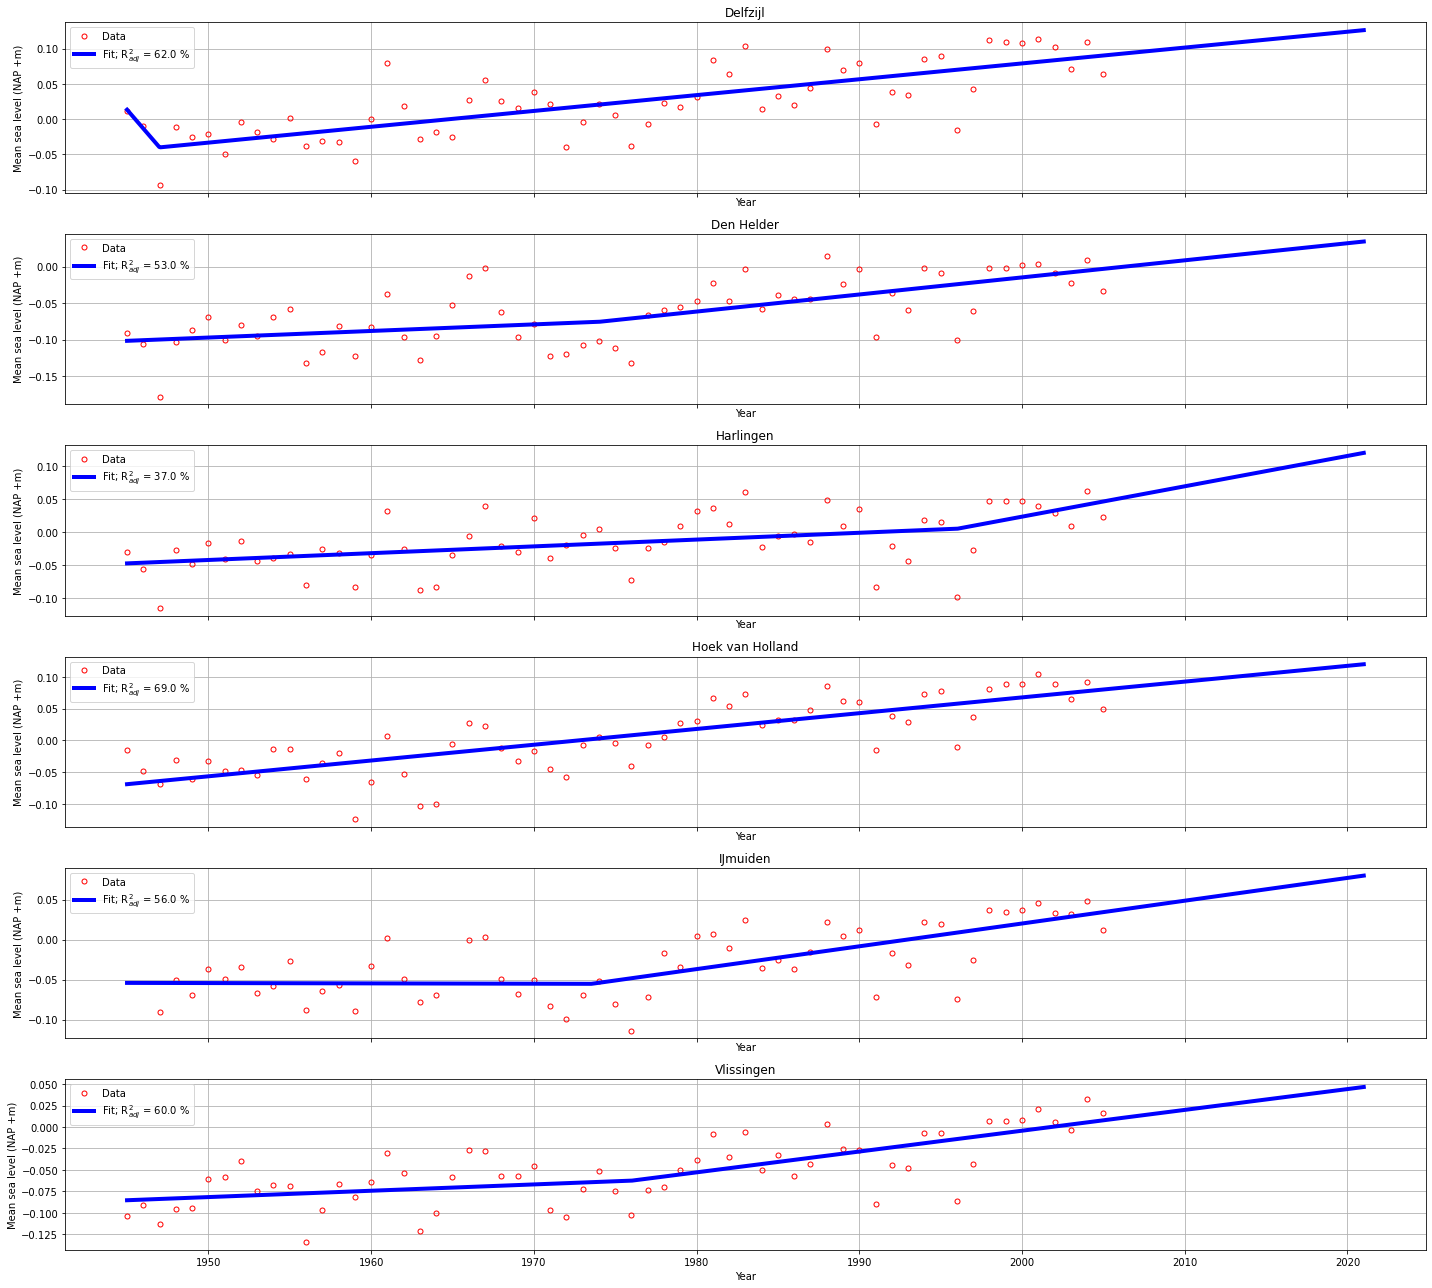

In [11]:
xgr = np.linspace(1945, 2021, 1000)

fig, ax = plt.subplots(nrows = 6, ncols = 1, sharex = True, sharey = False, figsize = figsize)

for i, nm in enumerate(df['naam'].unique()):
    data = df[df['naam'] == nm]
    plt.subplot(6,1,i+1)
    gf.plot_general_fit(
        mdl.model5, xgr, data['year'], data['z0'],
        pred_int = False,
        xlabel = 'Year', ylabel = 'Mean sea level (NAP +m)',
        title = nm, size = (13,5), method = 'Bence', conf_int = False
    )
    
    #plt.savefig(r'../pics/z0_model3.jpg')
    

#### Breakpoint testing with F-test

In [12]:
res = pd.DataFrame()
for nm in df['naam'].unique():
    data = df[df['naam'] == nm]

    tmp = pd.DataFrame()
    p = []
    yr = []
    stat = []
    y_model1, kred = sup.generate_model_data(
        mdl.model1, data['year'], data['z0']
    )
    
    for x in data['year']:
        y_model5, kfull = sup.generate_model_data(
            mdl.model5 , data['year'], data['z0'],
            bounds = (
                [-np.inf, -np.inf, -np.inf, x - 0.05 - data['year'].mean()],
                [np.inf, np.inf, np.inf, x - data['year'].mean()])
        )
        p.append(
            gof.Ftest_red(
                data['z0'], y_model5, y_model1,
                kfull, kred, 
                method = 'Bence', 
                alpha = 0.05)['p']
        )
        
        yr.append(x)
        stat.append(nm)
        
    tmp['year'] = yr
    tmp['naam'] = stat
    tmp['p'] = p

    res = pd.concat([res, tmp])              

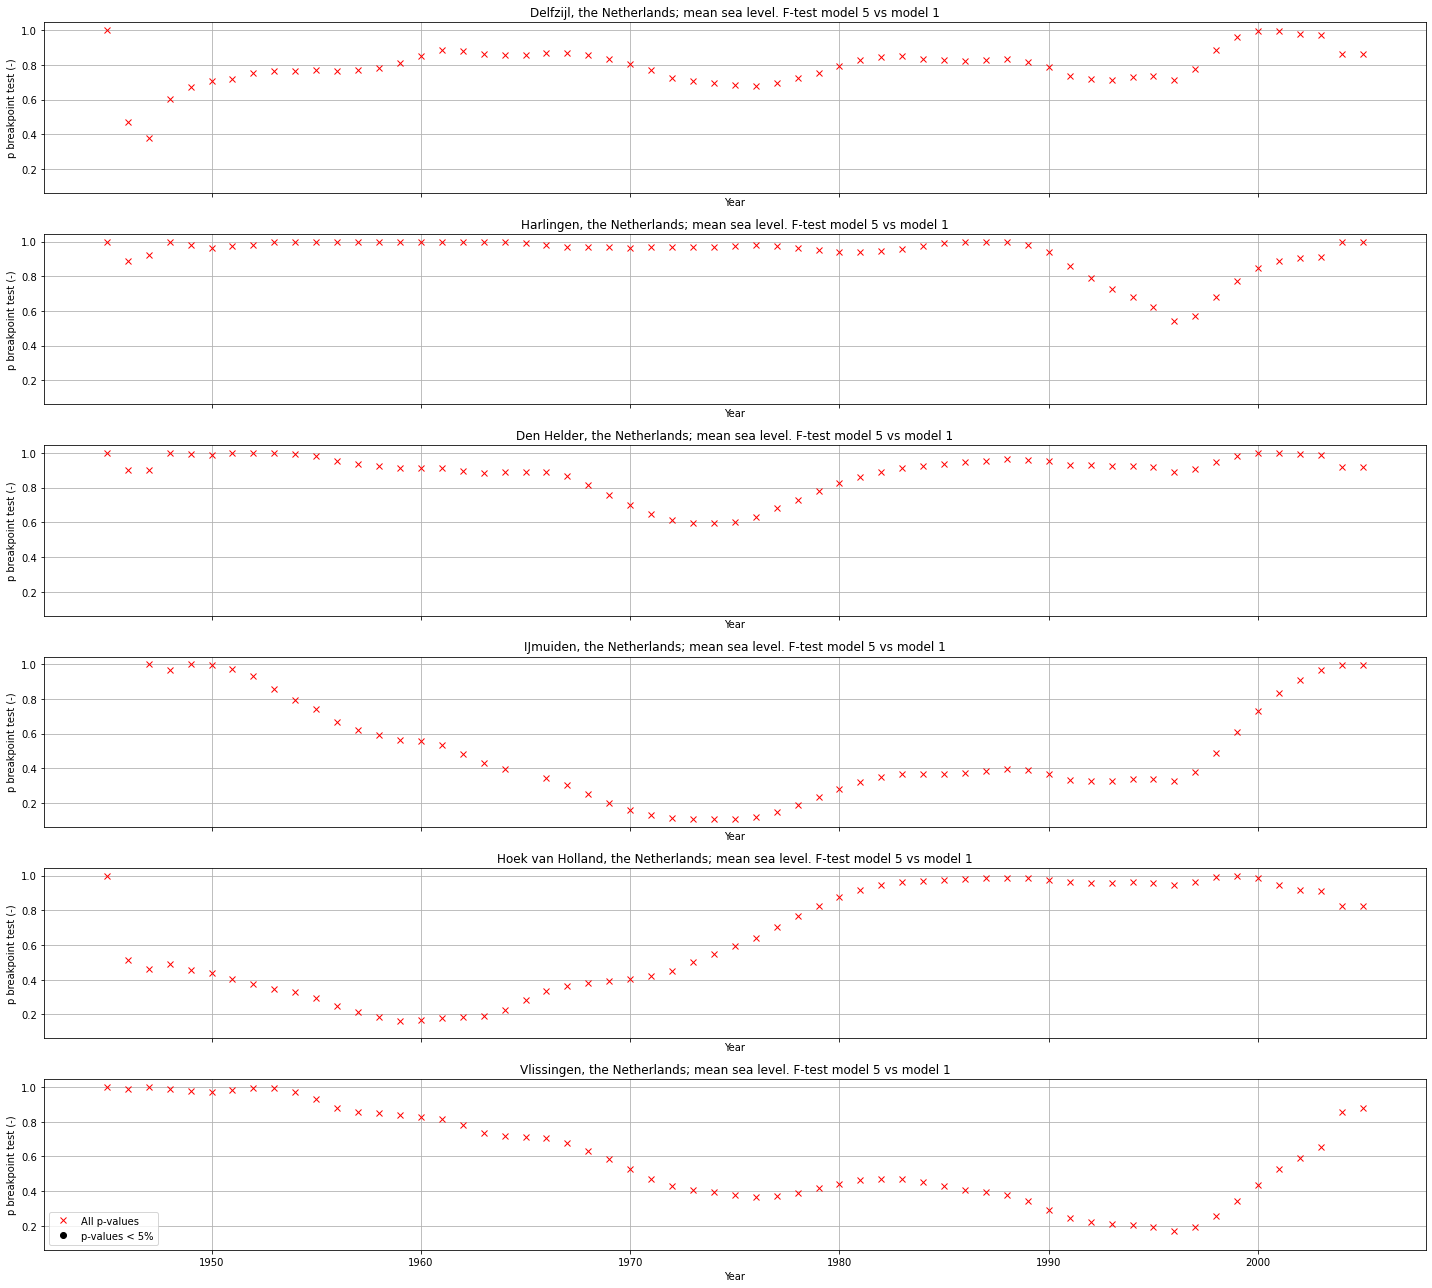

In [13]:
fig, ax = plt.subplots(nrows = 6, ncols = 1, sharex = True, sharey = True, figsize = figsize)
for i, nm in enumerate(names):
    data = res[res['naam'] == nm]
    ax[i].plot(
        data['year'], data['p'], 'rx', label = 'All p-values'
    )

    ax[i].set_ylabel('p breakpoint test (-)')
    ax[i].set_xlabel('Year')
    #ax[i].legend()
    ax[i].title.set_text(nm + ", the Netherlands; mean sea level. F-test model 5 vs model 1")
    #ax[i].set_yscale('log')

    data = data[data['p']<0.05]
    ax[i].plot(data['year'], data['p'],'ko', label = 'p-values < 5%')
    #ax[i].set_ylim(0.5, 1)
    #plt.xlim([1953, 1953.5])

plt.legend()
plt.tight_layout()
plt.savefig(r'../pics/breakpoint_test.jpg');

#### End script
Prepared by HVEC lab, 2022